# Стохастический анализ (2024)
# Домашнее Задание 4

ВАШЕ ИМЯ ЗДЕСЬ

Оценка: ?? из 100


Задачи: ?? из 

Ноутбук: ?? из 40


Дедлайн: ??, 2359МСК

Решённый ноутбук нужно засабмитить в класрум курса

Пожалуйста, называйте файл(ы) в формате <Имя>HW4.pdf или <Имя>HW4.ipynb. Например, KaledinHW4.pdf и KaledinHW4.ipynb.

# Стохастический анализ (2024)
# Домашнее Задание 4

ВАШЕ ИМЯ ЗДЕСЬ

Оценка: ?? из 100


Задачи: ?? из 

Ноутбук: ?? из 40


Дедлайн: ??, 2359МСК

Решённый ноутбук нужно засабмитить в класрум курса

Пожалуйста, называйте файл(ы) в формате <Имя>HW4.pdf или <Имя>HW4.ipynb. Например, KaledinHW4.pdf и KaledinHW4.ipynb.

In [1]:
#all imports here, pls
import numpy as np
import scipy.stats as spstats

import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

В этом ноутбуке мы более плотно поисследуем некоторые физические явления в микро- и макромасштабе с помощью численных методов, а также ещё посмотрим на MCMC в действии.

## Диффузии (30 баллов)


### (20 баллов) Алгоритмы семплирования

Мы будем исследовать две цепи: от алгоритма ULA и алгоритма MALA. Для реализации этих методов вам прежде всего понадобится метод Эйлера (используйте свою реализацию или дополните реализацию ниже).

In [2]:
class SDESolver:
    
    def __init__(self, b, sigma):
        self.b = b 
        self.sigma = sigma
    
    def step(self, x, t, tnext):
        """One integration step

        Raises:
            NotImplementedError: if not implemented
        """        
        raise NotImplementedError
    
    #added returnLast to not store everything
    #added kwargs to send additional arguments to step through solve
    def solve(self, x0, ts, returnLast=False, loaderLabel="Solving....", **kwargs):
        """Computes the solution on the given grid ts with x0 as initial condition

        Args:
            x0 float[]: initial condition (N,d,) or (d,)
            ts float[]: time grid (T,)
            tIds float[]: optional, ids in the dense time grid (sent through kwargs, needed for experiments)
        Returns:
            xs float[]: approximated solution (N,d,T) at points ts
        """
        try:
            if(len(x0.shape)==1):
                x0 = x0[None, :]
        except:
            #a number?
            x0 = np.ones([1,1])*x0
            
        
        if(returnLast):
            xs = x0    
        else:            
            xs = np.zeros([x0.shape[0], x0.shape[1], len(ts)])
            xs[...,0] = x0
        
        print(loaderLabel)
        for i in tqdm.tqdm(np.arange(1,len(ts))):
            if(returnLast):
                xs = self.step(xs,ts[i-1],ts[i],**kwargs)
            else:
                xs[...,i] = self.step(xs[...,i-1],ts[i-1],ts[i],**kwargs)
        
        return xs
    
class EulerSolver(SDESolver):
    
    def __init__(self,b,sigma):
        super(EulerSolver, self).__init__(b,sigma)
        
    def step(self, x, t, tnext,**kwargs):
        """Makes Euler step

        Args:
            x float[]: previous point (N,d)
            t float: previous time
            tnext float: next time
        """            
        #b (N,d)  x (N,d)   sigma (N,d,d)
        #NEW!! improved to handle sigma as matrix
        if(x.ndim==1): #in case we still got (d,)
            x = x[None,:]
        
        dw = np.random.standard_normal(size=x.shape)[:, None, :] * np.sqrt(tnext - t)
        res = x + self.b(t, x) * (tnext - t) + np.sum(self.sigma(t, x) * dw, axis=-1)
        return res

Ещё нам понадобится обёртка для семплера, семплер ULA и семплер MALA.

In [3]:
class Sampler:
    
    def __init__(self):
        pass
    
    def sample(self, N):
        """Samles N points

        Args:
            N (int): number of points to sample

        Raises:
            NotImplementedError: since needs override
        """        
        raise NotImplementedError

#for simplicity, a start sampler
class ConstSampler(Sampler):
    
    def __init__(self, const):
        '''
        Returns a const vector const (d,)
        '''
        self.const = const
        
    def sample(self,N):
        return self.const[None,:]*np.ones([N,1])
    
    
class GaussianSampler(Sampler):
    
    def __init__(self, mu, cov):
        self.mu = mu
        self.cov = cov
    
    def sample(self,N):
        return np.random.multivariate_normal(self.mu,self.cov, size=(N,))
    
class UniformSampler(Sampler):
    
    def __init__(self, left, right):
        self.left = left
        self.right = right
    
    def sample(self,N):
        return np.random.uniform(size=(N,self.left.shape[0]))*(self.right - self.left) + (self.right + self.left)/2
    
    
class ULASampler(Sampler):
    
    def __init__(self, gradLog, startSampler, delta=0.01):
        """
        Args:
            gradLog functionHandler: function mapping R^d tp R^d, gradient of the logarithm
            delta float: discrete time step, defaults to 0.01
            startSampler functionHandler: maps int N to a set of N samples
        """        
        super(ULASampler,self).__init__()
        self.gradLog = gradLog
        self.delta = delta
        self.startSampler = startSampler
        
        #pass t because of solver
        def sigg(t,x):
            return np.sqrt(2)*np.eye(x.shape[1])[None,...] * np.ones([x.shape[0],x.shape[1],x.shape[1]])
        self.solver = EulerSolver(self.gradLog,sigma=sigg)
        
    def sample(self, N, burnIn=20000, parallelChains=False):
        """Samles N points

        Args:
            N (int): number of points to sample
            burnIn (int): number of samples to burn before sampling

        Raises:
            NotImplementedError: since needs override
        """        
        Tburned = burnIn*self.delta
        tsBurn = np.arange(0,Tburned+3*self.delta/2,self.delta)#if you need it....
        if(parallelChains):
            #CASE of parallel sampling: run N chains in parallel, collect the last state
            startPoints = self.startSampler.sample(N)
            print("Sampling...")
            result = self.solver.solve(startPoints, tsBurn, returnLast=True)
        else:
            #CASE of sequential sampling: wait and then collect, one trajectory
            startPoints = self.startSampler.sample(1)
            startPoints = self.solver.solve(startPoints, tsBurn, returnLast=True)
            result = np.zeros([N,startPoints.shape[-1]])
            result[0,:] = startPoints
            print("Sampling...")
            for i in tqdm.tqdm(np.arange(1,N)):
                startPoints = self._odeStep(startPoints)
                result[i, :] = startPoints
            #result (N,d) is the sample of N observations
                
        return result
    
    def _odeStep(self,x):
        #one step of the solver
        return self.solver.step(x,0,self.delta)

Проверим теперь ULASampler на простом примере семплирования из $\mathcal{N}(1,1)$. Постройте диффузию Ланжевена для семплирования из этого распределения.

$$\nabla \ln \mathcal{N}(x; 1, 1) = \nabla \ln \left(\frac{1}{\sqrt{2\pi}} \exp\left(-\frac{(x-1)^2}{2}\right)\right) = \nabla -\frac{(x-1)^2}{2} = -(x-1)$$

$$dX_t = -(x-1)dt + \sqrt{2}dW_t$$

In [4]:
#pass t because of solver
def gradLog(t,x):
    return -(x-1)

startSampler = ConstSampler(np.zeros([1]))
delta = 0.001
ulaSampler = ULASampler(gradLog,startSampler,delta)

In [5]:
sampleParallel = ulaSampler.sample(10000,burnIn=100000, parallelChains=True)
sampleSequential = ulaSampler.sample(10000,burnIn=100000, parallelChains=False)
print(sampleParallel.shape,sampleSequential.shape)

Sampling...
Solving....


  0%|          | 0/100001 [00:00<?, ?it/s]

100%|██████████| 100001/100001 [00:15<00:00, 6258.14it/s]


Solving....


100%|██████████| 100001/100001 [00:01<00:00, 88384.30it/s]


Sampling...


100%|██████████| 9999/9999 [00:00<00:00, 72605.41it/s]

(10000, 1) (10000, 1)


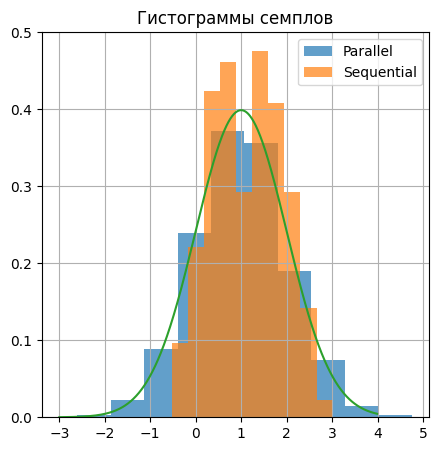

In [6]:
f, ax = plt.subplots(figsize=(5,5))

ax.grid()
ax.set_title("Гистограммы семплов")
ax.hist(sampleParallel[:,0], alpha=0.7,density=True,)
ax.hist(sampleSequential[:,0], alpha=0.7,density=True)
ax.legend(["Parallel","Sequential"])

xx = np.arange(-3,4,0.01)
normPDF = spstats.norm.pdf(xx-1)
ax.plot(xx,normPDF)

У Sequential-версии распределение немного отличается в силу коррелированности семплов, но у обеих версий примерно в одном месте находятся мода и матожидание.

Теперь алгоритм MALA. Он несильно отличается от ULA, но нам понадобится дополнительно знание плотности с точностью до константы нормировки.

Ещё нужно явно выписать пропоузал, он НЕсимметричный и его надо вычислять. Нужно с точностью до нормировочной константы(она сократится) вычислить

$$
q(X' \vert X_t) \propto \exp\big(-\frac{1}{4\tau}\|X' - X_t - \tau\nabla\ln p(X_t)\|_2^2\big)
$$

$$
q(X_t \vert X') \propto \exp\big(-\frac{1}{4\tau}\|X_t - X' - \tau\nabla\ln p(X')\|_2^2\big)
$$

Запишите формулы для плотностей пропоузала в ULA ниже (это важно! потом может быть очень сложно искать ошибку).

$$X'\sim\mathcal{N}(X_t + \tau\nabla \ln p(X_t), 2\tau)$$

In [7]:
class MALASampler(ULASampler):
    
    def __init__(self, gradLog, startSampler, density=None, logdensity=None, delta=0.01):
        """
        Args:
            gradLog functionHandler: function mapping R^d tp R^d, gradient of the logarithm
            delta float: discrete time step, defaults to 0.01
            startSampler functionHandler: maps int N to a set of N samples
            density functionHandler: maps R^d tp R, density function up to normalization constant
        """        
        super(MALASampler,self).__init__(gradLog, startSampler, delta)
        self.density = density
        self.logdensity = logdensity
        
    def sample(self, N, burnIn=20000, parallelChains=False):
        """Samles N points

        Args:
            N (int): number of points to sample
            burnIn (int): number of samples to burn before sampling

        Raises:
            NotImplementedError: since needs override
        """        

        if(parallelChains):
            #CASE of parallel sampling: run N chains in parallel, collect the last state
            startPoints = self.startSampler.sample(N)
            print("Burning...")
            for i in tqdm.tqdm(np.arange(burnIn)):
                startPoints = self._MHStep(startPoints)
            print("Sampling...")
            result = startPoints
        else:
            #CASE of sequential sampling: wait and then collect, one trajectory
            startPoints = self.startSampler.sample(1)
            print("Burning...")
            for i in np.arange(burnIn):
                startPoints = self._MHStep(startPoints)
            result = np.zeros([N,startPoints.shape[-1]])
            result[0,:] = startPoints
            print("Sampling...")
            for i in tqdm.tqdm(np.arange(1,N)):
                startPoints = self._MHStep(startPoints)
                result[i, :] = startPoints
                
        return result
    
    def _odeStep(self,x):
        return self.solver.step(x,0,self.delta)
    
    def _MHStep(self, x):
        
        xNew = self._odeStep(x)
        
        #calculate proposal log densities 
        #x->xNew
        xxNewLogDens = -1 / (4 * self.delta) * np.sum(xNew - x - self.delta * self.gradLog(0, x), axis=1) ** 2
        #xNew->x
        xNewxLogDens = -1 / (4 * self.delta) * np.sum(x - xNew - self.delta * self.gradLog(0, xNew), axis=1) ** 2
        
        #calculate acceptance probability
        #use np.log WHEREVER YOU CAN for numerical stability
        if self.density is not None:
            log_accRatios = np.log(self.density(xNew)) + xNewxLogDens - np.log(self.density(x)) - xxNewLogDens
        else:
            log_accRatios = self.logdensity(xNew) + xNewxLogDens - self.logdensity(x) - xxNewLogDens
        acceptProbs = np.exp(np.minimum(log_accRatios, 0))
        accepted = np.random.uniform(size=acceptProbs.shape) < acceptProbs
        
        #make a decision
        return accepted[:,None]*xNew + (1-accepted)[:,None]*x

In [8]:
#pass t because of solver
def gradLog(t,x):
    return -(x-1)
def density(x):
    return np.exp(-(x-1)**2/2).squeeze()

startSampler = ConstSampler(np.zeros([1]))
delta = 0.01
malaSampler = MALASampler(gradLog,startSampler,density,delta=delta)

In [9]:
sampleParallel = malaSampler.sample(10000,burnIn=100000, parallelChains=True)
sampleSequential = malaSampler.sample(10000,burnIn=100000, parallelChains=False)
print(sampleParallel.shape,sampleSequential.shape)

Burning...


100%|██████████| 100000/100000 [00:49<00:00, 2002.41it/s]


Sampling...
Burning...
Sampling...


100%|██████████| 9999/9999 [00:00<00:00, 30967.59it/s]

(10000, 1) (10000, 1)


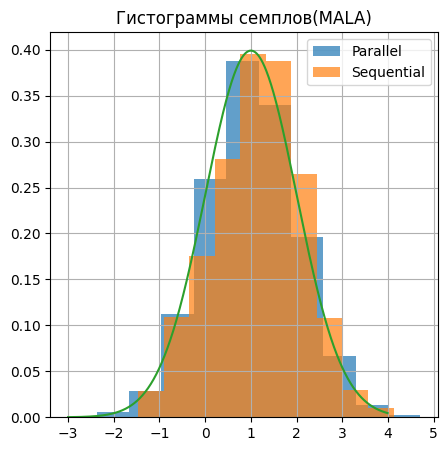

In [10]:
f, ax = plt.subplots(figsize=(5,5))

ax.grid()
ax.set_title("Гистограммы семплов(MALA)")
ax.hist(sampleParallel[:,0], alpha=0.7,density=True,)
ax.hist(sampleSequential[:,0], alpha=0.7,density=True)
ax.legend(["Parallel","Sequential"])

xx = np.arange(-3,4,0.01)
normPDF = spstats.norm.pdf(xx-1)
ax.plot(xx,normPDF)

Сходимость не зависит от того, с какого распределения мы стартовали. Давайте попробуем семплировать из такого же распределения, но запустим два варианта цепи (обе в режиме sequential): с началом в  $7$ и с началом в $-4$.

Нарисуйте ниже графики, где по оси х отложено время, а по оси y -- значения цепей. Не забуьте про $\texttt{burnIn}$.

In [11]:
#pass t because of solver
def gradLog(t,x):
    return -(x-1)
def density(x):
    return np.exp(-(x-1)**2/2).squeeze()

startSampler1 = ConstSampler(np.array([7]))
startSampler2 = ConstSampler(np.array([-5]))
delta = 0.01
malaSampler1 = MALASampler(gradLog,startSampler1,density,delta)
malaSampler2 = MALASampler(gradLog,startSampler2,density,delta)
ulaSampler1 = ULASampler(gradLog,startSampler1,delta)
ulaSampler2 = ULASampler(gradLog,startSampler2,delta)

In [12]:
experiments = {"MALA1": {"sampler":malaSampler1},
               "MALA2": {"sampler":malaSampler2},
               "ULA1": {"sampler":ulaSampler1},
               "ULA2": {"sampler":ulaSampler2}}
expResults = {expId: exp["sampler"].sample(10000,burnIn=1, parallelChains=False) for expId,exp in experiments.items()}

Burning...
Sampling...


100%|██████████| 9999/9999 [00:00<00:00, 31110.38it/s]


Burning...
Sampling...


100%|██████████| 9999/9999 [00:00<00:00, 31519.43it/s]


Solving....


100%|██████████| 2/2 [00:00<00:00, 30727.50it/s]


Sampling...


100%|██████████| 9999/9999 [00:00<00:00, 90267.16it/s]


Solving....


100%|██████████| 2/2 [00:00<00:00, 32896.50it/s]


Sampling...


100%|██████████| 9999/9999 [00:00<00:00, 70017.11it/s]


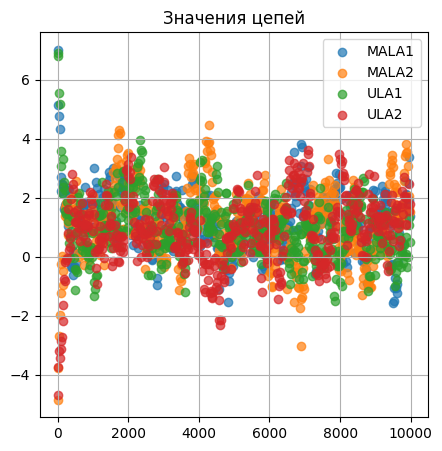

In [13]:
f, ax = plt.subplots(figsize=(5,5))

ax.grid()
ax.set_title("Значения цепей")

expKeys = list(experiments.keys())
for key in expKeys:
    ax.scatter(np.arange(expResults[key].shape[0])[::20],expResults[key].squeeze()[::20],alpha=0.7)

ax.legend(expKeys)

MALA мало смысла запускать с плохого старта из региона с низкой плотностью, потому что мы часто будем отклонять семпл. Поэтому если алгоритм не сходится, всегда можно начать с ULA.

## Плотность посложнее (10 баллов)

Рассмотрим диффузию в $\mathbb{R}^2$

$$
dX_t = b(X_t)dt + \sqrt{2} dW_t, \quad b(x,y) = -0.5[x/250 + 8x(y+2x^2-10), ~ 2(y+2x^2-10) ]^T
$$

Вычислите стационарную плотность этой диффузии.

Можно проинтегрировать по каждой компоненте, а потом собрать в один ответ:

$$\int -0.5(x/250 + 8x(y+2x^2-10))dx = -0.5(x^2/500 + 4x^2y+4x^4-40x^2) + C$$

$$\int -0.5(2(y+2x^2-10)) dy = -0.5 (y^2 + 4x^2y - 20y) + C$$

$$p(x) = \exp\left(-\frac{1}{2}(x^2/500 + 4x^2y+4x^4-40x^2 +y^2  - 20y) + C\right) = С_0\exp\left(-\frac{1}{2}(x^2/500 + 4x^2y+4x^4-40x^2 +y^2  - 20y)\right)$$

### (5 баллов) Семплирование

Постройте семплы спомощью алгоритмов MALA и ULA из начального распределения, которое вам кажется удобнее, обоснуйте свой выбор.

Запустите параллельно $1000$ цепей для каждого алгоритма и нарисуйте на плоскости их положения в разные моменты времени $t=1,1000,10000,100000$(вам поможет реинициализация с помощью ConstExactSampler). Когда примерно цепь доходит до эргодического состояния? Попробуйте разные размеры шага $\texttt{delta}=0.01,0.1,0.001$, как изменятся результаты работы алгоритма? Для стартового разогрева можно использовать ULA, если в MALA много отвержений, а потом перейти на MALA.

In [14]:
#pass t because of solver

def gradLog(t,x):
    return - 0.5 * np.array([x[:, 0] / 250 + 8 * x[:, 0] * (x[:, 1] + 2 * x[:, 0] ** 2 - 10), 2 * (x[:, 1] + 2 * x[:, 0] ** 2 - 10)]).T
def logDensity(x):
    return -0.5 * (x[:, 0] ** 2 / 500 + 4 * x[:, 0] ** 2 * x[:, 1] + 4 * x[:, 0] ** 4 - 40 * x[:, 0] ** 2 + x[:, 1] ** 2 - 20 * x[:, 1])

In [18]:
startSampler = GaussianSampler(np.zeros([2])+4,np.array([[1,0],[0,1]]))
delta = 0.1
ulaSampler01 = ULASampler(gradLog, startSampler, delta)
malaSampler01 = MALASampler(gradLog, startSampler, logdensity=logDensity, delta=delta)
ulasamples01 = ulaSampler01.sample(1000,burnIn=100000, parallelChains=True)
malasamples01 = malaSampler01.sample(1000,burnIn=100000, parallelChains=True)

Sampling...
Solving....


  0%|          | 0/100001 [00:00<?, ?it/s]/var/folders/n6/f0pmc36s6nbcbbqtyldp_frm0000gn/T/ipykernel_94127/2967908261.py:4: RuntimeWarning: overflow encountered in square
  return - 0.5 * np.array([x[:, 0] / 250 + 8 * x[:, 0] * (x[:, 1] + 2 * x[:, 0] ** 2 - 10), 2 * (x[:, 1] + 2 * x[:, 0] ** 2 - 10)]).T
/var/folders/n6/f0pmc36s6nbcbbqtyldp_frm0000gn/T/ipykernel_94127/2967908261.py:4: RuntimeWarning: overflow encountered in multiply
  return - 0.5 * np.array([x[:, 0] / 250 + 8 * x[:, 0] * (x[:, 1] + 2 * x[:, 0] ** 2 - 10), 2 * (x[:, 1] + 2 * x[:, 0] ** 2 - 10)]).T
/var/folders/n6/f0pmc36s6nbcbbqtyldp_frm0000gn/T/ipykernel_94127/2967908261.py:4: RuntimeWarning: invalid value encountered in add
  return - 0.5 * np.array([x[:, 0] / 250 + 8 * x[:, 0] * (x[:, 1] + 2 * x[:, 0] ** 2 - 10), 2 * (x[:, 1] + 2 * x[:, 0] ** 2 - 10)]).T
/var/folders/n6/f0pmc36s6nbcbbqtyldp_frm0000gn/T/ipykernel_94127/3832277580.py:69: RuntimeWarning: invalid value encountered in add
  res = x + self.b(t, x) * (tnext

Burning...


100%|██████████| 100000/100000 [00:18<00:00, 5380.34it/s]

Sampling...


In [19]:
delta = 0.01
ulaSampler001 = ULASampler(gradLog,startSampler,delta)
malaSampler001 = MALASampler(gradLog, startSampler, logdensity=logDensity, delta=delta)
ulasamples001 = ulaSampler001.sample(1000,burnIn=100000, parallelChains=True)
malasamples001 = malaSampler001.sample(1000,burnIn=100000, parallelChains=True)

Sampling...
Solving....


  0%|          | 0/100001 [00:00<?, ?it/s]/var/folders/n6/f0pmc36s6nbcbbqtyldp_frm0000gn/T/ipykernel_94127/2967908261.py:4: RuntimeWarning: overflow encountered in square
  return - 0.5 * np.array([x[:, 0] / 250 + 8 * x[:, 0] * (x[:, 1] + 2 * x[:, 0] ** 2 - 10), 2 * (x[:, 1] + 2 * x[:, 0] ** 2 - 10)]).T
/var/folders/n6/f0pmc36s6nbcbbqtyldp_frm0000gn/T/ipykernel_94127/2967908261.py:4: RuntimeWarning: overflow encountered in multiply
  return - 0.5 * np.array([x[:, 0] / 250 + 8 * x[:, 0] * (x[:, 1] + 2 * x[:, 0] ** 2 - 10), 2 * (x[:, 1] + 2 * x[:, 0] ** 2 - 10)]).T
/var/folders/n6/f0pmc36s6nbcbbqtyldp_frm0000gn/T/ipykernel_94127/2967908261.py:4: RuntimeWarning: invalid value encountered in add
  return - 0.5 * np.array([x[:, 0] / 250 + 8 * x[:, 0] * (x[:, 1] + 2 * x[:, 0] ** 2 - 10), 2 * (x[:, 1] + 2 * x[:, 0] ** 2 - 10)]).T
/var/folders/n6/f0pmc36s6nbcbbqtyldp_frm0000gn/T/ipykernel_94127/3832277580.py:69: RuntimeWarning: invalid value encountered in add
  res = x + self.b(t, x) * (tnext

Burning...


100%|██████████| 100000/100000 [00:18<00:00, 5339.63it/s]

Sampling...


In [20]:
delta = 0.001
ulaSampler0001 = ULASampler(gradLog,startSampler,delta)
malaSampler0001 = MALASampler(gradLog, startSampler, logdensity=logDensity, delta=delta)
ulasamples0001 = ulaSampler0001.sample(1000,burnIn=100000, parallelChains=True)
malasamples0001 = malaSampler0001.sample(1000,burnIn=100000, parallelChains=True)

Sampling...
Solving....


100%|██████████| 100001/100001 [00:07<00:00, 12763.07it/s]


Burning...


100%|██████████| 100000/100000 [00:24<00:00, 4054.95it/s]

Sampling...


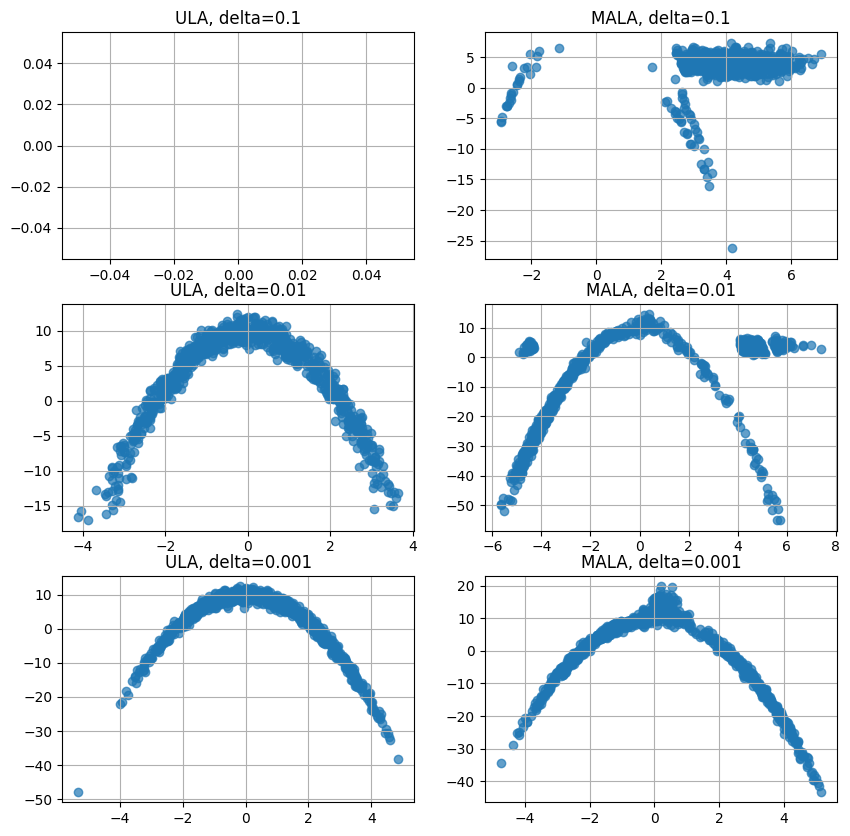

In [27]:
f, ax = plt.subplots(3, 2, figsize=(10,10))


ax[0, 0].scatter(ulasamples01[:,0],ulasamples01[:,1],alpha=0.7)
ax[0, 0].set_title('ULA, delta=0.1, t=100000')
ax[0, 0].grid()
ax[0, 1].scatter(malasamples01[:,0],malasamples01[:,1],alpha=0.7)
ax[0, 1].set_title('MALA, delta=0.1, t=100000')
ax[0, 1].grid()


ax[1, 0].scatter(ulasamples001[:,0],ulasamples001[:,1],alpha=0.7)
ax[1, 0].set_title('ULA, delta=0.01, t=100000')
ax[1, 0].grid()

ax[1, 1].scatter(malasamples001[:,0],malasamples001[:,1],alpha=0.7)
ax[1, 1].set_title('MALA, delta=0.01, t=100000')
ax[1, 1].grid()


ax[2, 0].scatter(ulasamples0001[:,0],ulasamples0001[:,1],alpha=0.7)
ax[2, 0].set_title('ULA, delta=0.001, t=100000')
ax[2, 0].grid()

ax[2, 1].scatter(malasamples0001[:,0],malasamples0001[:,1],alpha=0.7)
ax[2, 1].set_title('MALA, delta=0.001, t=100000')
ax[2, 1].grid()


Sampling...
Solving....


  0%|          | 0/10001 [00:00<?, ?it/s]/var/folders/n6/f0pmc36s6nbcbbqtyldp_frm0000gn/T/ipykernel_94127/2967908261.py:4: RuntimeWarning: overflow encountered in square
  return - 0.5 * np.array([x[:, 0] / 250 + 8 * x[:, 0] * (x[:, 1] + 2 * x[:, 0] ** 2 - 10), 2 * (x[:, 1] + 2 * x[:, 0] ** 2 - 10)]).T
/var/folders/n6/f0pmc36s6nbcbbqtyldp_frm0000gn/T/ipykernel_94127/2967908261.py:4: RuntimeWarning: overflow encountered in multiply
  return - 0.5 * np.array([x[:, 0] / 250 + 8 * x[:, 0] * (x[:, 1] + 2 * x[:, 0] ** 2 - 10), 2 * (x[:, 1] + 2 * x[:, 0] ** 2 - 10)]).T
/var/folders/n6/f0pmc36s6nbcbbqtyldp_frm0000gn/T/ipykernel_94127/2967908261.py:4: RuntimeWarning: invalid value encountered in add
  return - 0.5 * np.array([x[:, 0] / 250 + 8 * x[:, 0] * (x[:, 1] + 2 * x[:, 0] ** 2 - 10), 2 * (x[:, 1] + 2 * x[:, 0] ** 2 - 10)]).T
/var/folders/n6/f0pmc36s6nbcbbqtyldp_frm0000gn/T/ipykernel_94127/3832277580.py:69: RuntimeWarning: invalid value encountered in add
  res = x + self.b(t, x) * (tnext 

Burning...


100%|██████████| 10000/10000 [00:01<00:00, 5174.60it/s]


Sampling...
Sampling...
Solving....


100%|██████████| 10001/10001 [00:00<00:00, 12387.54it/s]


Burning...


100%|██████████| 10000/10000 [00:01<00:00, 5023.52it/s]


Sampling...
Sampling...
Solving....


100%|██████████| 10001/10001 [00:00<00:00, 13416.65it/s]


Burning...


100%|██████████| 10000/10000 [00:01<00:00, 5220.41it/s]


Sampling...


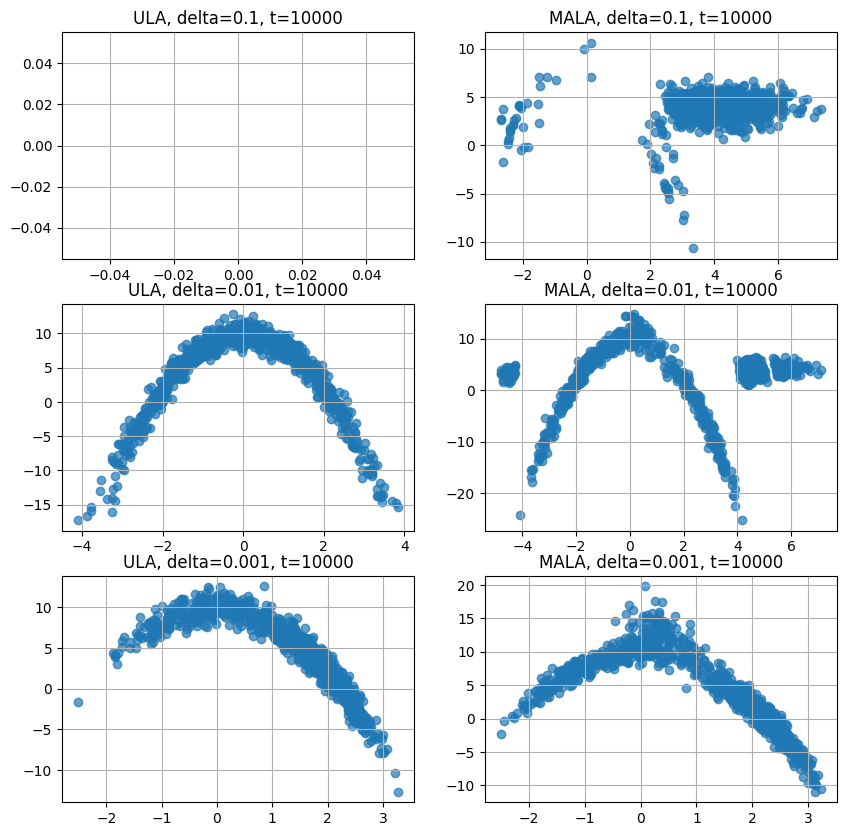

In [28]:
startSampler = GaussianSampler(np.zeros([2])+4,np.array([[1,0],[0,1]]))
delta = 0.1
ulaSampler01 = ULASampler(gradLog, startSampler, delta)
malaSampler01 = MALASampler(gradLog, startSampler, logdensity=logDensity, delta=delta)
ulasamples01 = ulaSampler01.sample(1000,burnIn=10000, parallelChains=True)
malasamples01 = malaSampler01.sample(1000,burnIn=10000, parallelChains=True)

delta = 0.01
ulaSampler001 = ULASampler(gradLog,startSampler,delta)
malaSampler001 = MALASampler(gradLog, startSampler, logdensity=logDensity, delta=delta)
ulasamples001 = ulaSampler001.sample(1000,burnIn=10000, parallelChains=True)
malasamples001 = malaSampler001.sample(1000,burnIn=10000, parallelChains=True)

delta = 0.001
ulaSampler0001 = ULASampler(gradLog,startSampler,delta)
malaSampler0001 = MALASampler(gradLog, startSampler, logdensity=logDensity, delta=delta)
ulasamples0001 = ulaSampler0001.sample(1000,burnIn=10000, parallelChains=True)
malasamples0001 = malaSampler0001.sample(1000,burnIn=10000, parallelChains=True)

f, ax = plt.subplots(3, 2, figsize=(10,10))


ax[0, 0].scatter(ulasamples01[:,0],ulasamples01[:,1],alpha=0.7)
ax[0, 0].set_title('ULA, delta=0.1, t=10000')
ax[0, 0].grid()
ax[0, 1].scatter(malasamples01[:,0],malasamples01[:,1],alpha=0.7)
ax[0, 1].set_title('MALA, delta=0.1, t=10000')
ax[0, 1].grid()


ax[1, 0].scatter(ulasamples001[:,0],ulasamples001[:,1],alpha=0.7)
ax[1, 0].set_title('ULA, delta=0.01, t=10000')
ax[1, 0].grid()

ax[1, 1].scatter(malasamples001[:,0],malasamples001[:,1],alpha=0.7)
ax[1, 1].set_title('MALA, delta=0.01, t=10000')
ax[1, 1].grid()


ax[2, 0].scatter(ulasamples0001[:,0],ulasamples0001[:,1],alpha=0.7)
ax[2, 0].set_title('ULA, delta=0.001, t=10000')
ax[2, 0].grid()

ax[2, 1].scatter(malasamples0001[:,0],malasamples0001[:,1],alpha=0.7)
ax[2, 1].set_title('MALA, delta=0.001, t=10000')
ax[2, 1].grid()


Sampling...
Solving....


  0%|          | 0/1001 [00:00<?, ?it/s]/var/folders/n6/f0pmc36s6nbcbbqtyldp_frm0000gn/T/ipykernel_94127/2967908261.py:4: RuntimeWarning: overflow encountered in square
  return - 0.5 * np.array([x[:, 0] / 250 + 8 * x[:, 0] * (x[:, 1] + 2 * x[:, 0] ** 2 - 10), 2 * (x[:, 1] + 2 * x[:, 0] ** 2 - 10)]).T
/var/folders/n6/f0pmc36s6nbcbbqtyldp_frm0000gn/T/ipykernel_94127/2967908261.py:4: RuntimeWarning: overflow encountered in multiply
  return - 0.5 * np.array([x[:, 0] / 250 + 8 * x[:, 0] * (x[:, 1] + 2 * x[:, 0] ** 2 - 10), 2 * (x[:, 1] + 2 * x[:, 0] ** 2 - 10)]).T
/var/folders/n6/f0pmc36s6nbcbbqtyldp_frm0000gn/T/ipykernel_94127/2967908261.py:4: RuntimeWarning: invalid value encountered in add
  return - 0.5 * np.array([x[:, 0] / 250 + 8 * x[:, 0] * (x[:, 1] + 2 * x[:, 0] ** 2 - 10), 2 * (x[:, 1] + 2 * x[:, 0] ** 2 - 10)]).T
/var/folders/n6/f0pmc36s6nbcbbqtyldp_frm0000gn/T/ipykernel_94127/3832277580.py:69: RuntimeWarning: invalid value encountered in add
  res = x + self.b(t, x) * (tnext -

Burning...


100%|██████████| 1000/1000 [00:00<00:00, 4586.93it/s]


Sampling...
Sampling...
Solving....


100%|██████████| 1001/1001 [00:00<00:00, 8607.87it/s]


Burning...


100%|██████████| 1000/1000 [00:00<00:00, 5756.92it/s]


Sampling...
Sampling...
Solving....


100%|██████████| 1001/1001 [00:00<00:00, 6396.70it/s]


Burning...


100%|██████████| 1000/1000 [00:00<00:00, 4583.16it/s]


Sampling...


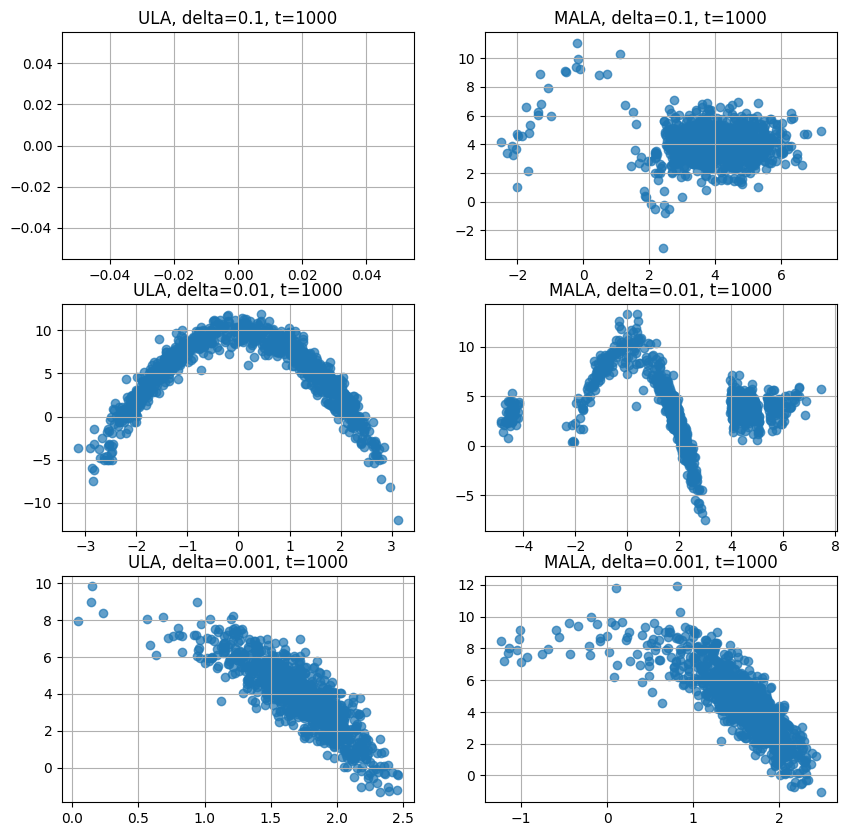

In [29]:
startSampler = GaussianSampler(np.zeros([2])+4,np.array([[1,0],[0,1]]))
delta = 0.1
ulaSampler01 = ULASampler(gradLog, startSampler, delta)
malaSampler01 = MALASampler(gradLog, startSampler, logdensity=logDensity, delta=delta)
ulasamples01 = ulaSampler01.sample(1000,burnIn=1000, parallelChains=True)
malasamples01 = malaSampler01.sample(1000,burnIn=1000, parallelChains=True)

delta = 0.01
ulaSampler001 = ULASampler(gradLog,startSampler,delta)
malaSampler001 = MALASampler(gradLog, startSampler, logdensity=logDensity, delta=delta)
ulasamples001 = ulaSampler001.sample(1000,burnIn=1000, parallelChains=True)
malasamples001 = malaSampler001.sample(1000,burnIn=1000, parallelChains=True)

delta = 0.001
ulaSampler0001 = ULASampler(gradLog,startSampler,delta)
malaSampler0001 = MALASampler(gradLog, startSampler, logdensity=logDensity, delta=delta)
ulasamples0001 = ulaSampler0001.sample(1000,burnIn=1000, parallelChains=True)
malasamples0001 = malaSampler0001.sample(1000,burnIn=1000, parallelChains=True)

f, ax = plt.subplots(3, 2, figsize=(10,10))


ax[0, 0].scatter(ulasamples01[:,0],ulasamples01[:,1],alpha=0.7)
ax[0, 0].set_title('ULA, delta=0.1, t=1000')
ax[0, 0].grid()
ax[0, 1].scatter(malasamples01[:,0],malasamples01[:,1],alpha=0.7)
ax[0, 1].set_title('MALA, delta=0.1, t=1000')
ax[0, 1].grid()


ax[1, 0].scatter(ulasamples001[:,0],ulasamples001[:,1],alpha=0.7)
ax[1, 0].set_title('ULA, delta=0.01, t=1000')
ax[1, 0].grid()

ax[1, 1].scatter(malasamples001[:,0],malasamples001[:,1],alpha=0.7)
ax[1, 1].set_title('MALA, delta=0.01, t=1000')
ax[1, 1].grid()


ax[2, 0].scatter(ulasamples0001[:,0],ulasamples0001[:,1],alpha=0.7)
ax[2, 0].set_title('ULA, delta=0.001, t=1000')
ax[2, 0].grid()

ax[2, 1].scatter(malasamples0001[:,0],malasamples0001[:,1],alpha=0.7)
ax[2, 1].set_title('MALA, delta=0.001, t=1000')
ax[2, 1].grid()


Sampling...
Solving....


100%|██████████| 2/2 [00:00<00:00, 2173.78it/s]


Burning...


100%|██████████| 1/1 [00:00<00:00, 702.21it/s]


Sampling...
Sampling...
Solving....


100%|██████████| 2/2 [00:00<00:00, 3559.02it/s]


Burning...


100%|██████████| 1/1 [00:00<00:00, 862.67it/s]


Sampling...
Sampling...
Solving....


100%|██████████| 2/2 [00:00<00:00, 2024.28it/s]


Burning...


100%|██████████| 1/1 [00:00<00:00, 1009.22it/s]

Sampling...


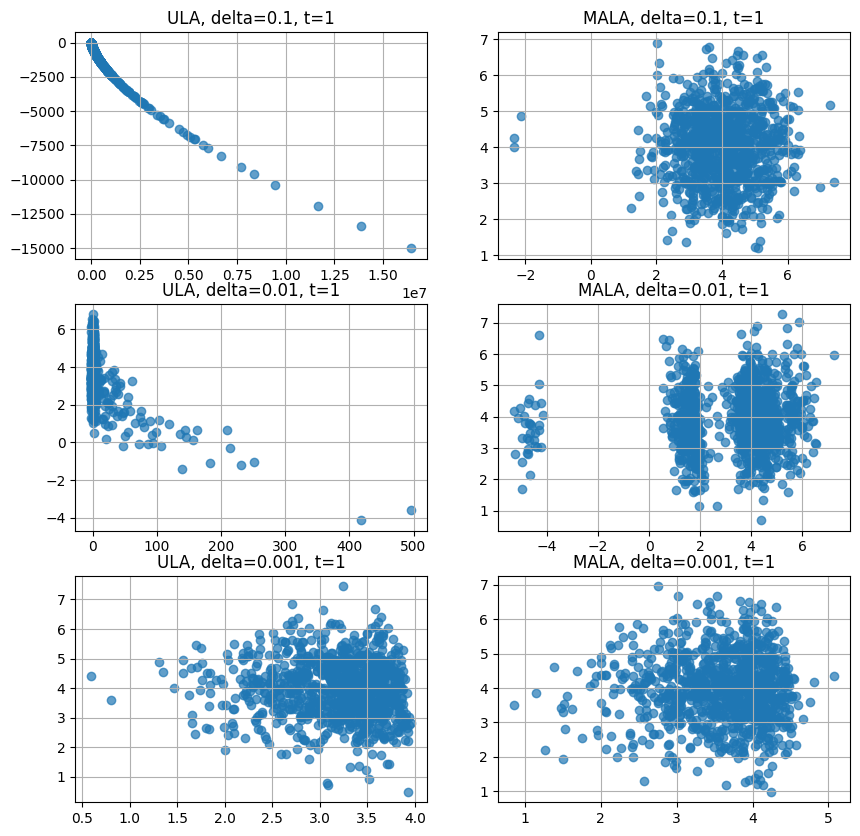

In [31]:
startSampler = GaussianSampler(np.zeros([2])+4,np.array([[1,0],[0,1]]))
delta = 0.1
ulaSampler01 = ULASampler(gradLog, startSampler, delta)
malaSampler01 = MALASampler(gradLog, startSampler, logdensity=logDensity, delta=delta)
ulasamples01 = ulaSampler01.sample(1000,burnIn=1, parallelChains=True)
malasamples01 = malaSampler01.sample(1000,burnIn=1, parallelChains=True)

delta = 0.01
ulaSampler001 = ULASampler(gradLog,startSampler,delta)
malaSampler001 = MALASampler(gradLog, startSampler, logdensity=logDensity, delta=delta)
ulasamples001 = ulaSampler001.sample(1000,burnIn=1, parallelChains=True)
malasamples001 = malaSampler001.sample(1000,burnIn=1, parallelChains=True)

delta = 0.001
ulaSampler0001 = ULASampler(gradLog,startSampler,delta)
malaSampler0001 = MALASampler(gradLog, startSampler, logdensity=logDensity, delta=delta)
ulasamples0001 = ulaSampler0001.sample(1000,burnIn=1, parallelChains=True)
malasamples0001 = malaSampler0001.sample(1000,burnIn=1, parallelChains=True)

f, ax = plt.subplots(3, 2, figsize=(10,10))


ax[0, 0].scatter(ulasamples01[:,0],ulasamples01[:,1],alpha=0.7)
ax[0, 0].set_title('ULA, delta=0.1, t=1')
ax[0, 0].grid()
ax[0, 1].scatter(malasamples01[:,0],malasamples01[:,1],alpha=0.7)
ax[0, 1].set_title('MALA, delta=0.1, t=1')
ax[0, 1].grid()


ax[1, 0].scatter(ulasamples001[:,0],ulasamples001[:,1],alpha=0.7)
ax[1, 0].set_title('ULA, delta=0.01, t=1')
ax[1, 0].grid()

ax[1, 1].scatter(malasamples001[:,0],malasamples001[:,1],alpha=0.7)
ax[1, 1].set_title('MALA, delta=0.01, t=1')
ax[1, 1].grid()


ax[2, 0].scatter(ulasamples0001[:,0],ulasamples0001[:,1],alpha=0.7)
ax[2, 0].set_title('ULA, delta=0.001, t=1')
ax[2, 0].grid()

ax[2, 1].scatter(malasamples0001[:,0],malasamples0001[:,1],alpha=0.7)
ax[2, 1].set_title('MALA, delta=0.001, t=1')
ax[2, 1].grid()


Не знаю, что я сделал не так, но при delta = 0.1 всё в переполнениях(((. По графикам если честно не могу много сказать: чем больше t, тем лучше получается стационарная плотность, ну и ещё видно, что ULA раньше что ли получает нужную картинку, думаю, что это именно из-за того, что в MALA мы можем отвергать сэмплы.